# Q2: ViT for classification

## data preprocess

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append((filename, img))
    return images

directories = {
    'NEUTROPHIL': '/content/drive/MyDrive/data/BCCD/NEUTROPHIL',
    'EOSINOPHIL': '/content/drive/MyDrive/data/BCCD/EOSINOPHIL',
    'MONOCYTE': '/content/drive/MyDrive/data/BCCD/MONOCYTE',
    'LYMPHOCYTE': '/content/drive/MyDrive/data/BCCD/LYMPHOCYTE'
}

data = []
for label, folder in directories.items():
    imgs = load_images_from_folder(folder)
    for img in imgs:
        data.append((label, img[0], img[1]))

df = pd.DataFrame(data, columns=['label', 'filename', 'image'])

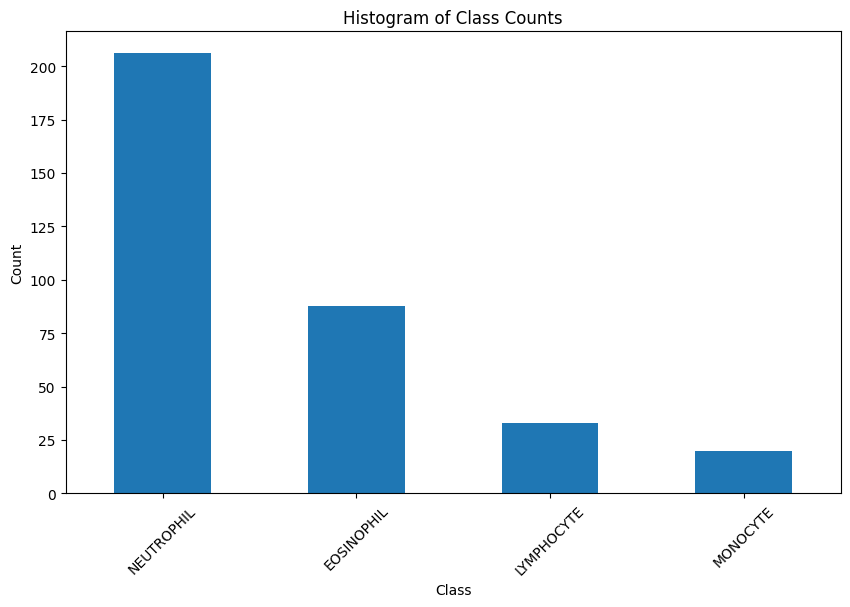

In [4]:
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [5]:
import albumentations as A
from albumentations.core.bbox_utils import convert_bboxes_to_albumentations, convert_bboxes_from_albumentations
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]
)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
augmented_data = []

for class_name, count in class_counts.items():
    class_samples = df[df['label'] == class_name]

    while sum(1 if (x['label']==class_name) else 0 for x in augmented_data)<(250 - count):
        sample = class_samples.sample(n=1).iloc[0]
        image_path = os.path.join('/content/drive/MyDrive/data/BCCD', sample['label'],sample['filename'])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = transform(image=image)
        augmented_image = augmented['image']

        augmented_data.append({
            'label': class_name,
            'filename': f"aug_{len(augmented_data)}_{sample['filename']}.jpg",
            'image': augmented_image,
        })


In [7]:
augmented_df = pd.DataFrame(augmented_data)
augmented_df = pd.concat([df, augmented_df], ignore_index=True)

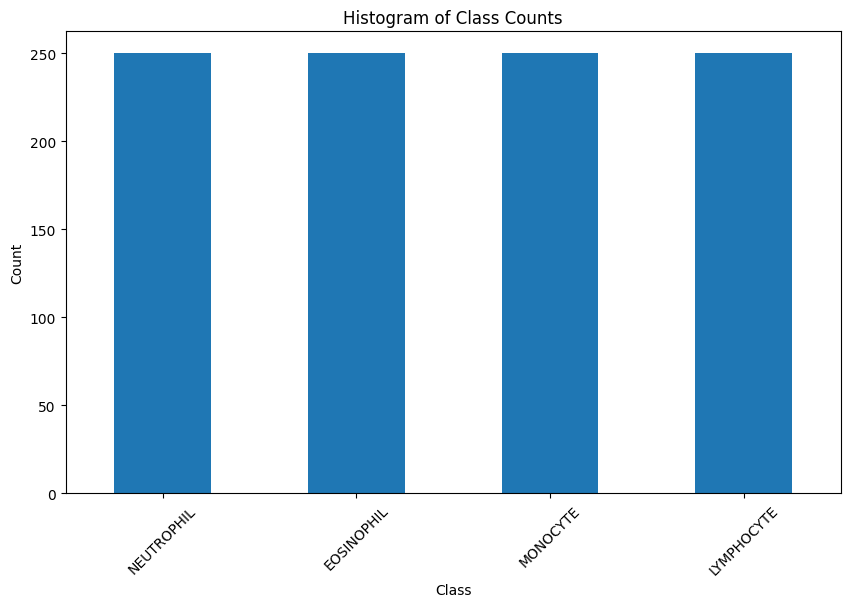

In [8]:
class_counts = augmented_df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
class WBCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']

        if self.transform:
            img = self.transform(img)

        return img, label

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(augmented_df, test_size=0.2, random_state=42, stratify=augmented_df['label'])

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

train_dataset = WBCDataset(train_df, transform=transform)
test_dataset = WBCDataset(test_df, transform=transform)

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## ViT Model

In [14]:
from transformers import ViTFeatureExtractor
import torch

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [15]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
model.eval()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [16]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [20]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [28]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [26]:
label_mapping = {label: idx for idx, label in enumerate(augmented_df['label'].unique())}

In [29]:
from sklearn.metrics import classification_report

print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.27      0.94      0.43        50
  EOSINOPHIL       0.00      0.00      0.00        50
    MONOCYTE       0.86      0.12      0.21        50
  LYMPHOCYTE       0.45      0.20      0.28        50

    accuracy                           0.32       200
   macro avg       0.40      0.32      0.23       200
weighted avg       0.40      0.32      0.23       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Training Classifier

In [47]:
classifier_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
classifier_ft_model.to(device)

for name, param in classifier_ft_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in classifier_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight is trainable.
classifier.bias is trainable.


In [31]:
from torch.optim import Adam

optimizer = Adam([{'params': classifier_ft_model.classifier.parameters(), 'lr': 1e-4},], lr=1e-4)

classifier_ft_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = classifier_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]))

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.2391437292099
Epoch 2, Loss: 1.1363211870193481
Epoch 3, Loss: 1.0534695386886597
Epoch 4, Loss: 0.987982988357544
Epoch 5, Loss: 0.9349544644355774
Epoch 6, Loss: 0.8910014629364014
Epoch 7, Loss: 0.8538058400154114
Epoch 8, Loss: 0.8217426538467407
Epoch 9, Loss: 0.7936569452285767
Epoch 10, Loss: 0.7687147855758667


In [32]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = classifier_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [33]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.75      0.72      0.73        50
  EOSINOPHIL       0.65      0.70      0.67        50
    MONOCYTE       0.81      0.78      0.80        50
  LYMPHOCYTE       0.92      0.92      0.92        50

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



In [34]:
total_params = sum(p.numel() for p in classifier_ft_model.parameters())

trainable_params = sum(p.numel() for p in classifier_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 3076


### first 2 layers

In [48]:
first2_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
first2_ft_model.to(device)

for name, param in first2_ft_model.named_parameters():
    if ("vit.encoder.layer.0." not in name) and ("vit.encoder.layer.1." not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in first2_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.encoder.layer.0.attention.attention.query.weight is trainable.
vit.encoder.layer.0.attention.attention.query.bias is trainable.
vit.encoder.layer.0.attention.attention.key.weight is trainable.
vit.encoder.layer.0.attention.attention.key.bias is trainable.
vit.encoder.layer.0.attention.attention.value.weight is trainable.
vit.encoder.layer.0.attention.attention.value.bias is trainable.
vit.encoder.layer.0.attention.output.dense.weight is trainable.
vit.encoder.layer.0.attention.output.dense.bias is trainable.
vit.encoder.layer.0.intermediate.dense.weight is trainable.
vit.encoder.layer.0.intermediate.dense.bias is trainable.
vit.encoder.layer.0.output.dense.weight is trainable.
vit.encoder.layer.0.output.dense.bias is trainable.
vit.encoder.layer.0.layernorm_before.weight is trainable.
vit.encoder.layer.0.layernorm_before.bias is trainable.
vit.encoder.layer.0.layernorm_after.weight is trainable.
vit.encoder.layer.0.layernorm_after.bias is trainable.
vit.encoder.layer.1.attention.at

In [49]:
total_params = sum(p.numel() for p in first2_ft_model.parameters())

trainable_params = sum(p.numel() for p in first2_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 14175744


In [51]:
from torch.optim import Adam

optimizer = Adam([{'params': first2_ft_model.parameters(), 'lr': 1e-4},], lr=1e-4)

first2_ft_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = first2_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]).to(device))

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.8721432685852051
Epoch 2, Loss: 0.5699049830436707
Epoch 3, Loss: 0.3719389736652374
Epoch 4, Loss: 0.19514860212802887
Epoch 5, Loss: 0.11993348598480225
Epoch 6, Loss: 0.10586684197187424
Epoch 7, Loss: 0.0975966602563858
Epoch 8, Loss: 0.19840513169765472
Epoch 9, Loss: 0.0603814423084259
Epoch 10, Loss: 0.050911784172058105


In [52]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = first2_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [53]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.90      0.92      0.91        50
  EOSINOPHIL       0.92      0.90      0.91        50
    MONOCYTE       1.00      1.00      1.00        50
  LYMPHOCYTE       1.00      1.00      1.00        50

    accuracy                           0.95       200
   macro avg       0.96      0.96      0.95       200
weighted avg       0.96      0.95      0.95       200



### last 2 layers

In [54]:
last2_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
last2_ft_model.to(device)

for name, param in last2_ft_model.named_parameters():
    if ("vit.encoder.layer.10" not in name) and ("vit.encoder.layer.11" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in last2_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.encoder.layer.10.attention.attention.query.weight is trainable.
vit.encoder.layer.10.attention.attention.query.bias is trainable.
vit.encoder.layer.10.attention.attention.key.weight is trainable.
vit.encoder.layer.10.attention.attention.key.bias is trainable.
vit.encoder.layer.10.attention.attention.value.weight is trainable.
vit.encoder.layer.10.attention.attention.value.bias is trainable.
vit.encoder.layer.10.attention.output.dense.weight is trainable.
vit.encoder.layer.10.attention.output.dense.bias is trainable.
vit.encoder.layer.10.intermediate.dense.weight is trainable.
vit.encoder.layer.10.intermediate.dense.bias is trainable.
vit.encoder.layer.10.output.dense.weight is trainable.
vit.encoder.layer.10.output.dense.bias is trainable.
vit.encoder.layer.10.layernorm_before.weight is trainable.
vit.encoder.layer.10.layernorm_before.bias is trainable.
vit.encoder.layer.10.layernorm_after.weight is trainable.
vit.encoder.layer.10.layernorm_after.bias is trainable.
vit.encoder.laye

In [55]:
total_params = sum(p.numel() for p in last2_ft_model.parameters())

trainable_params = sum(p.numel() for p in last2_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 14175744


In [56]:
from torch.optim import Adam

optimizer = Adam([{'params': last2_ft_model.parameters(), 'lr': 1e-4},], lr=1e-4)

last2_ft_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = last2_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]))

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6074689030647278
Epoch 2, Loss: 0.16466721892356873
Epoch 3, Loss: 0.058155663311481476
Epoch 4, Loss: 0.03470772132277489
Epoch 5, Loss: 0.04804759472608566
Epoch 6, Loss: 0.010982001200318336
Epoch 7, Loss: 0.009497925639152527
Epoch 8, Loss: 0.1501631736755371
Epoch 9, Loss: 0.00441426457837224
Epoch 10, Loss: 0.00220480072312057


In [57]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = last2_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [58]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.89      0.94      0.91        50
  EOSINOPHIL       0.94      0.88      0.91        50
    MONOCYTE       0.98      1.00      0.99        50
  LYMPHOCYTE       1.00      0.98      0.99        50

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



### all layers

In [62]:
all_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
all_ft_model.to(device)

for name, param in all_ft_model.named_parameters():
    param.requires_grad = True

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
total_params = sum(p.numel() for p in all_ft_model.parameters())

trainable_params = sum(p.numel() for p in all_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 85801732


In [64]:
from torch.optim import Adam

optimizer = Adam([{'params': all_ft_model.parameters(), 'lr': 1e-4},], lr=1e-4)

all_ft_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = all_ft_model(pixel_values=images.to(device), labels=torch.tensor([label_mapping[i] for i in labels]))

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.30018454790115356
Epoch 2, Loss: 0.257131427526474
Epoch 3, Loss: 0.22238250076770782
Epoch 4, Loss: 0.0018189080292358994
Epoch 5, Loss: 0.0764915943145752
Epoch 6, Loss: 0.011374254710972309
Epoch 7, Loss: 0.0026538344100117683
Epoch 8, Loss: 0.009648350067436695
Epoch 9, Loss: 0.0007959044305607677
Epoch 10, Loss: 0.07967516034841537


In [65]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = all_ft_model(pixel_values=imgs.to(device))
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [66]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.90      0.92      0.91        50
  EOSINOPHIL       0.94      0.90      0.92        50
    MONOCYTE       0.98      1.00      0.99        50
  LYMPHOCYTE       0.98      0.98      0.98        50

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



## CNN

In [67]:
import torch
import torch.nn as nn
from torchvision import models

cnn_model = models.densenet121(pretrained=True)
cnn_model.classifier = nn.Linear(cnn_model.classifier.in_features, 4)
cnn_model.to(device)
cnn_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 109MB/s] 


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [70]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = cnn_model(imgs.to(device))
        batch_predictions = torch.argmax(outputs, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [71]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.00      0.00      0.00        50
  EOSINOPHIL       0.21      0.54      0.30        50
    MONOCYTE       0.00      0.00      0.00        50
  LYMPHOCYTE       0.23      0.26      0.24        50

    accuracy                           0.20       200
   macro avg       0.11      0.20      0.14       200
weighted avg       0.11      0.20      0.14       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### all layers

In [72]:
all_cnn_model = models.densenet121(pretrained=True)
all_cnn_model.classifier = nn.Linear(all_cnn_model.classifier.in_features, 4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
total_params = sum(p.numel() for p in all_cnn_model.parameters())

trainable_params = sum(p.numel() for p in all_cnn_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 6957956
Trainable parameters: 6957956


In [74]:
loss_fn = nn.CrossEntropyLoss()

In [77]:
from torch.optim import Adam

optimizer = Adam([{'params': all_cnn_model.parameters(), 'lr': 1e-4},], lr=1e-4)
all_cnn_model.to(device)
all_cnn_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = all_cnn_model(images.to(device))
        loss = loss_fn(outputs.to(device), torch.tensor([label_mapping[i] for i in labels]).to(device))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.34314247965812683
Epoch 2, Loss: 0.09008631855249405
Epoch 3, Loss: 0.03441543132066727
Epoch 4, Loss: 0.02025562897324562
Epoch 5, Loss: 0.010911264456808567
Epoch 6, Loss: 0.00827191025018692
Epoch 7, Loss: 0.006410285364836454
Epoch 8, Loss: 0.005258388351649046
Epoch 9, Loss: 0.0044279820285737514
Epoch 10, Loss: 0.003783648833632469


In [78]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = all_cnn_model(imgs.to(device))
        batch_predictions = torch.argmax(outputs, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [79]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.89      0.94      0.91        50
  EOSINOPHIL       0.94      0.88      0.91        50
    MONOCYTE       0.98      1.00      0.99        50
  LYMPHOCYTE       1.00      0.98      0.99        50

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



### classifier

In [81]:
classifier_cnn_model = models.densenet121(pretrained=True)
classifier_cnn_model.classifier = nn.Linear(classifier_cnn_model.classifier.in_features, 4)
_=classifier_cnn_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [82]:
for name, param in classifier_cnn_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in classifier_cnn_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

classifier.weight is trainable.
classifier.bias is trainable.


In [83]:
total_params = sum(p.numel() for p in classifier_cnn_model.parameters())

trainable_params = sum(p.numel() for p in classifier_cnn_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 6957956
Trainable parameters: 4100


In [85]:
from torch.optim import Adam

optimizer = Adam([{'params': classifier_cnn_model.classifier.parameters(), 'lr': 1e-4},], lr=1e-4)

classifier_cnn_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch
        optimizer.zero_grad()

        outputs = classifier_cnn_model(images.to(device))
        loss = loss_fn(outputs.to(device), torch.tensor([label_mapping[i] for i in labels]).to(device))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 1.4287149906158447
Epoch 2, Loss: 1.4017584323883057
Epoch 3, Loss: 1.374266505241394
Epoch 4, Loss: 1.3482811450958252
Epoch 5, Loss: 1.323502540588379
Epoch 6, Loss: 1.2998112440109253
Epoch 7, Loss: 1.2771055698394775
Epoch 8, Loss: 1.2552995681762695
Epoch 9, Loss: 1.2343205213546753
Epoch 10, Loss: 1.2141060829162598


In [86]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = classifier_cnn_model(imgs.to(device))
        batch_predictions = torch.argmax(outputs, dim=1)

    predictions.extend(batch_predictions.cpu())
    ground_truth.extend(labels)

In [87]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  NEUTROPHIL       0.50      0.66      0.57        50
  EOSINOPHIL       0.42      0.54      0.47        50
    MONOCYTE       0.66      0.38      0.48        50
  LYMPHOCYTE       0.75      0.60      0.67        50

    accuracy                           0.55       200
   macro avg       0.58      0.55      0.55       200
weighted avg       0.58      0.55      0.55       200

